In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
# Set random seed for reproducibility
tf.random.set_seed(42)

In [3]:
# Data preparation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [4]:
# Assuming your data structure is:
# data/
#   Closed-Eyes/
#   Open-Eyes/
batch_size = 32
img_height = 64
img_width = 64

In [5]:
train_generator = train_datagen.flow_from_directory(
    'data2',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    'data2',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode='grayscale',
    subset='validation'
)


Found 67919 images belonging to 2 classes.
Found 16979 images belonging to 2 classes.


In [6]:
# Create the model
def create_eye_state_model():
    model = Sequential([
        # First Convolutional Block
        Conv2D(32, (3, 3), padding='same', activation='relu', 
               kernel_regularizer=l2(0.01), input_shape=(img_height, img_width, 1)),
        BatchNormalization(),
        Conv2D(32, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Second Convolutional Block
        Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Conv2D(64, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Third Convolutional Block
        Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),
        
        # Dense layers
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        
        # Output layer
        Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall()]
    )
    
    return model

In [7]:
# Create and train the model
model = create_eye_state_model()

In [8]:
# Define callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        'best_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        mode='max'
    )
]

In [9]:
# Train the model
history = model.fit(
    train_generator,
    epochs=200,
    validation_data=validation_generator,
    callbacks=callbacks
)

Epoch 1/200
2123/2123 [==============================] - 59s 27ms/step - loss: 1.4447 - accuracy: 0.8712 - precision: 0.8844 - recall: 0.8575 - val_loss: 0.6327 - val_accuracy: 0.8982 - val_precision: 0.9910 - val_recall: 0.8061
Epoch 2/200
2123/2123 [==============================] - 60s 28ms/step - loss: 0.4716 - accuracy: 0.9420 - precision: 0.9488 - recall: 0.9359 - val_loss: 0.5761 - val_accuracy: 0.8756 - val_precision: 0.8981 - val_recall: 0.8505
Epoch 3/200
2123/2123 [==============================] - 67s 32ms/step - loss: 0.3956 - accuracy: 0.9486 - precision: 0.9546 - recall: 0.9432 - val_loss: 0.7236 - val_accuracy: 0.7694 - val_precision: 0.7006 - val_recall: 0.9501
Epoch 4/200
2123/2123 [==============================] - 72s 34ms/step - loss: 0.3671 - accuracy: 0.9504 - precision: 0.9556 - recall: 0.9459 - val_loss: 0.5373 - val_accuracy: 0.8644 - val_precision: 0.9936 - val_recall: 0.7368
Epoch 5/200
2123/2123 [==============================] - 68s 32ms/step - loss: 0.316

In [10]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    
    # Loss plot
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

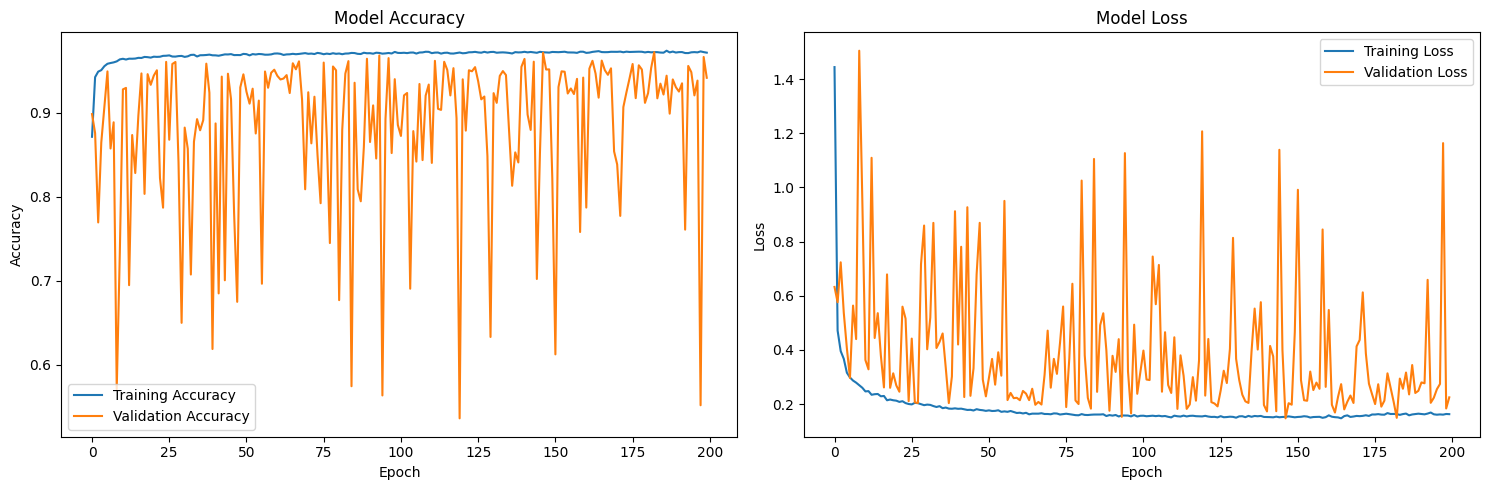

In [11]:
# Plot the training history
plot_training_history(history)

In [12]:
# Function to make predictions on new images
def predict_eye_state(image_path):
    img = tf.keras.preprocessing.image.load_img(
        image_path,
        target_size=(img_height, img_width),
        color_mode='grayscale'
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = tf.expand_dims(img_array, 0)
    
    prediction = model.predict(img_array)
    return "Open" if prediction[0] > 0.5 else "Closed"